In [6]:
import math
import pylab #?
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

def gen_data(N):
    x = np.random.randn(N, 1)
    w1 = 2
    b1 = 8
    sigma1 = 1e1 # ground truth
    y1 = x.dot(w1) + b1 + sigma1 * np.random.randn(N, 1)
    w2 = 3
    b2 = 3
    sigma2 = 1e0 # ground truth
    y2 = x.dot(w2) + b2 + sigma2 * np.random.randn(N, 1)
    return x, y1, y2

class TrainData(Dataset):
    def __init__(self, feature_num, x, y1, y2):
        self.feature_num = feature_num
        self.x = torch.tensor(x, dtype = torch.float32)
        self.y1 = torch.tensor(y1, dtype= torch.float32)
        self.y2 = torch.tensor(y2, dtype=torch.float32)
    
    def __len__(self):
        return self.feature_num
    
    def __getitem__(self, idx):
        return self.x[idx,:], self.y1[idx,:], self.y2[idx, :]
    
class MultiTaskLossWrapper(nn.Module):
    def __init__(self, task_num, model):
        super(MultiTaskLossWrapper, self).__init__()
        self.model = model
        self.task_num = task_num
        self.log_vars = nn.Parameter(torch.zeros((task_num)))  #?
        
    def forward(self, input, targets):
        outputs = self.model(input)
        
        precision1 = torch.exp(-self.log_vars[0])
        loss = torch.sum(precision1 * (targets[0] - outputs[0])**2. + self.log_vars[0], -1)
        
        precision2 = torch.exp(-self.log_vars[1])
        loss += torch.sum(precision2 * (targets[1] - outputs[1])**2. + self.log_vars[1], -1)
    
        loss = torch.mean(loss)

        return loss, self.log_Vars.data.tolist()
    
class MTLModel(nn.Module):
    def __init__(self, n_hidden, n_output):
        super(MTLModel, self).__init__()
        
        self.net1 = nn.Sequential(nn.Linear(1, n_hidden), nn.ReLU(), nn.Linear(n_hidden, n_output))
        self.net2 = nn.Sequential(nn.Linear(1, n_hidden), nn.ReLU(), nn.Linear(n_hidden, n_output))
        
    def forward(self, x):
        return [self.net1(x), self.net2(x)]
    
    

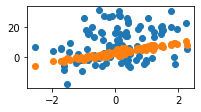

In [4]:
np.random.seed(0)

feature_num = 100
nb_epoch = 2000
batch_size = 20
hidden_dim = 1024

x, y1, y2 = gen_data(feature_num)
pylab.figure(figsize=(3, 1.5))
pylab.scatter(x[:,0], y1[:,0])
pylab.scatter(x[:,0], y2[:,0])
pylab.show()

In [7]:
train_data = TrainData(feature_num, x, y1, y2)
train_data_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)

model = MTLModel(hidden_dim, 1)

mt1 = MultiTaskLossWrapper(2, model)
mt1

optimizer = torch.optim.Adam(mt1.parameters(), lr=0.001, eps=1e-07)

loss_list = []
for t in range(nb_epoch):
    cumulative_loss = 0
    for x, y1, y2 in train_data_loader:
        loss, log_vars = mt1(x, [y1, y2])
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        cumulative_loss += loss.item()
        
    loss_list.append(cumulative_loss/batch_size)
    
    

/Users/moadata/opt/anaconda3/envs/deephit-env/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/Users/moadata/opt/anaconda3/envs/deephit-env/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/Users/moadata/opt/anaconda3/envs/deephit-env/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


IndexError: index 41 is out of bounds for dimension 0 with size 20

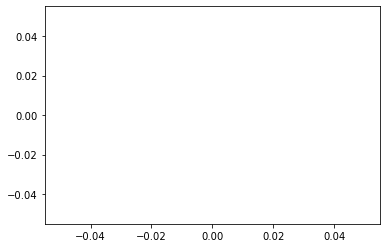

In [8]:
pylab.plot(loss_list)
pylab.show()

In [9]:
print(log_vars)


NameError: name 'log_vars' is not defined

In [10]:
# Found standard deviations (ground truth is 10 and 1)
print([math.exp(log_var)**0.5 for log_var in log_vars])

NameError: name 'log_vars' is not defined